**Общая информация**

**Срок сдачи:** 20 марта 2019, 06:00 <br\>
**Штраф за опоздание:** -1 балл после 06:00 20 марта, -2 балла после 06:00 27 марта, -3 балла после 06:00 3 апреля
-4 балла после 06:00 10 апреля

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack скинуть ссылку в личный чат @alkhamush
Пример ссылки:
https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##### Задание 1 (2 баллов)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

###### Задание 2 (2 балла)
Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy

###### Задание 3 (2 балла)
Для iris найдите такой параметр n_neighbors, при котором выдаётся наилучший score. Нарисуйте график зависимости score от n_neighbors

###### Задание 4 (3 балла)
Добавить algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

###### Задание 5 (1 балла)
Описать для чего нужны следующие библиотеки/классы/функции (список будет ниже)

**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять структуру кода и текст. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
%load_ext pycodestyle_magic

In [2]:
#%%pycodestyle

from scipy.spatial.distance import cdist
from sklearn.preprocessing import normalize
from scipy.stats import mode

from scipy.spatial import KDTree

class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin, ClassifierMixin):
    
    def __init__(self, n_neighbors, algorithm='brute'):
        self.neighbors = n_neighbors
        self.algorithm = algorithm
    
    def fit(self, X, y):
        if self.algorithm == 'kd_tree':
            self.data = KDTree(X)
        else:
            self.data = X
        
        self.labels = y
    
    def predict(self, X):
        if self.algorithm == 'kd_tree':
            indexes = self.data.query(X, k=self.neighbors)[1]
            
            # make a list of k neighbors targets
            k_nearest = self.labels[indexes].T
            
            # return most common values
            # numpy changes dtype of k_nearest to "np.ndarray" so workaround .astype(type(self.labels[0])
            return mode(k_nearest.astype(type(self.labels[0])), axis=0)[0]
        else:
            # calculate distances
            distances = cdist(self.data, X)

            # make a list of k neighbors targets
            indexes = np.argpartition(distances, self.neighbors, axis=0)
            
            k_nearest = self.labels[indexes[:self.neighbors]]

            # return most common values
            # numpy changes dtype of k_nearest to "np.ndarray" so workaround .astype(type(self.labels[0])
            return mode(k_nearest.astype(type(self.labels[0])), axis=0)[0]
        
    def predict_proba(self, X):
        if self.algorithm == 'kd_tree':
            indexes = self.data.query(X, k=self.neighbors)[1]
            
            k_nearest = self.labels[indexes]
            
        else:
            # calculate distances
            distances = cdist(self.data, X)

            # make a list of k neighbors targets
            indexes = np.argpartition(distances, self.neighbors, axis=0)
            k_nearest = self.labels[indexes[:self.neighbors]]
        
        unique = []
        pos = []
        
        for column in np.arange(0, k_nearest.shape[1]):
            cur_unique, cur_pos = np.unique(k_nearest[:, column], return_inverse=True)
            unique.append(cur_unique)
            pos.append(cur_pos)

        counts = np.asarray(list(map(lambda x: np.bincount(x), pos)))
    
        all_classes = np.unique(self.labels)
        all_rows = np.arange(0, X.shape[0])
        
        probabilities = []
        for row in all_rows:
            cur_probabilities = {key: 0 for key in all_classes}
            for cur_unique, cur_count in zip(unique[row], counts[row]):
                cur_probabilities[cur_unique] = cur_count
                
            probabilities.append((list(map(float, cur_probabilities.values()))))
            
        # normalize before returning
        return np.asarray(probabilities) / np.asarray(probabilities).sum(axis=1, keepdims=True)
    
    def score(self, X, y):
        return (self.predict(X) == y).sum() / y.size

**IRIS**

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
%time clf.fit(X_train, y_train)

CPU times: user 1.1 ms, sys: 445 µs, total: 1.55 ms
Wall time: 1.16 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [7]:
%time my_clf.fit(X_train, y_train)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 12.2 µs


In [8]:
%time clf.predict(X_test)

CPU times: user 2.88 ms, sys: 1.81 ms, total: 4.69 ms
Wall time: 4.6 ms


array([2, 2, 2, 0, 0, 0, 0, 0, 2, 1, 1, 1, 2, 1, 2])

In [9]:
%time my_clf.predict(X_test)

CPU times: user 2.11 ms, sys: 1.39 ms, total: 3.51 ms
Wall time: 2.31 ms


array([[2, 2, 2, 0, 0, 0, 0, 0, 2, 1, 1, 1, 2, 1, 2]])

In [10]:
%time clf.predict_proba(X_test)

CPU times: user 1.16 ms, sys: 596 µs, total: 1.76 ms
Wall time: 1.21 ms


array([[0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ]])

In [11]:
%time my_clf.predict_proba(X_test)

CPU times: user 2.45 ms, sys: 1.94 ms, total: 4.39 ms
Wall time: 3.12 ms


array([[0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ]])

In [12]:
clf.score(X_test, y_test)

0.8

In [13]:
my_clf.score(X_test, y_test)

0.8

Задание 3

highest score is at 1 neighbors


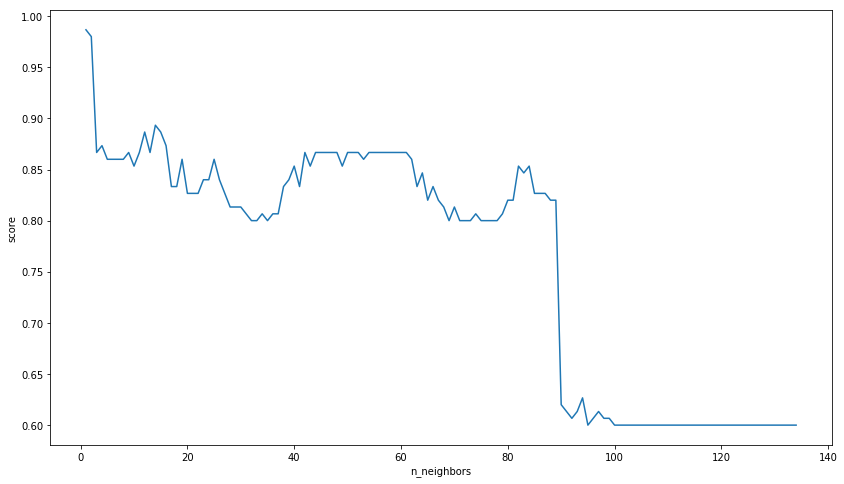

In [14]:
fig = plt.figure(figsize= (14,8))
ax = plt.subplot(111)

ax.set_xlabel('n_neighbors')
ax.set_ylabel('score')

scores = []
neighbors = np.arange(1,X_train.shape[0])
for neighbor in neighbors:
    my_clf = MyKNeighborsClassifier(n_neighbors=neighbor, algorithm='brute')
    cur_scores = np.empty(10)
    
    # calculate mean score
    fold = 10
    for i in range(0, fold):
        # handmade k-fold cross validation
        X_train, a, y_train, b = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)
        my_clf.fit(X_train, y_train)
        
        cur_scores[i] = my_clf.score(X_test, y_test)
    
    scores.append(cur_scores.mean())

plt.plot(neighbors, scores)

optimal_n = neighbors[scores.index(max(scores))]
print("highest score is at %d neighbors" % optimal_n)

**MNIST**

In [15]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')

In [16]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.01, stratify=mnist.target)

In [17]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [18]:
%time clf.fit(X_train, y_train)

CPU times: user 167 ms, sys: 2.6 ms, total: 170 ms
Wall time: 169 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [19]:
%time my_clf.fit(X_train, y_train)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 11.7 µs


In [20]:
%time clf.predict(X_test)

CPU times: user 3.32 s, sys: 283 ms, total: 3.6 s
Wall time: 2.19 s


array(['1', '9', '4', '7', '9', '5', '1', '3', '7', '5', '3', '9', '9',
       '6', '1', '9', '2', '3', '2', '1', '6', '6', '4', '2', '2', '3',
       '6', '8', '0', '3', '6', '3', '5', '3', '8', '5', '3', '5', '9',
       '5', '4', '0', '9', '1', '1', '4', '8', '1', '6', '9', '5', '0',
       '6', '0', '4', '6', '1', '9', '4', '8', '7', '9', '1', '6', '5',
       '2', '0', '8', '7', '4', '6', '1', '9', '3', '4', '2', '8', '5',
       '7', '8', '9', '4', '2', '0', '3', '6', '1', '3', '8', '9', '4',
       '9', '5', '7', '1', '1', '1', '9', '9', '3', '1', '7', '8', '6',
       '1', '7', '4', '4', '4', '1', '9', '6', '6', '6', '5', '1', '4',
       '2', '3', '0', '0', '5', '7', '8', '7', '6', '3', '6', '2', '6',
       '9', '7', '0', '2', '6', '7', '2', '9', '1', '2', '0', '5', '5',
       '1', '5', '0', '9', '9', '2', '1', '6', '9', '6', '7', '3', '0',
       '2', '7', '7', '5', '2', '5', '4', '8', '4', '2', '3', '0', '1',
       '0', '1', '8', '5', '4', '2', '3', '5', '9', '3', '0', '1

In [21]:
%time my_clf.predict(X_test)

CPU times: user 41 s, sys: 907 ms, total: 41.9 s
Wall time: 42.4 s


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


array([['1', '9', '4', '7', '9', '5', '1', '3', '7', '5', '3', '9', '9',
        '6', '1', '9', '2', '3', '2', '1', '6', '6', '4', '2', '2', '3',
        '6', '8', '0', '3', '6', '3', '5', '3', '8', '5', '3', '5', '9',
        '5', '4', '0', '9', '1', '1', '4', '8', '1', '6', '9', '5', '0',
        '6', '0', '4', '6', '1', '9', '4', '8', '7', '9', '1', '6', '5',
        '2', '0', '8', '7', '4', '6', '1', '9', '3', '4', '2', '8', '5',
        '7', '8', '9', '4', '2', '0', '3', '6', '1', '3', '8', '9', '4',
        '9', '5', '7', '1', '1', '1', '9', '9', '3', '1', '7', '8', '6',
        '1', '7', '4', '4', '4', '1', '9', '6', '6', '6', '5', '1', '4',
        '2', '3', '0', '0', '5', '7', '8', '7', '6', '3', '6', '2', '6',
        '9', '7', '0', '2', '6', '7', '2', '9', '1', '2', '0', '5', '5',
        '1', '5', '0', '9', '9', '2', '1', '6', '9', '6', '7', '3', '0',
        '2', '7', '7', '5', '2', '5', '4', '8', '4', '2', '3', '0', '1',
        '0', '1', '8', '5', '4', '2', '3', '5', '9'

In [22]:
%time clf.predict_proba(X_test)

CPU times: user 3.53 s, sys: 313 ms, total: 3.85 s
Wall time: 2.41 s


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
%time my_clf.predict_proba(X_test)

CPU times: user 41.1 s, sys: 952 ms, total: 42 s
Wall time: 42.7 s


array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [24]:
clf.score(X_test, y_test)

0.9714285714285714

In [25]:
my_clf.score(X_test, y_test)

/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:248: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


0.9714285714285714

Задание 4

In [26]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [27]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.01, stratify=mnist.target)

In [28]:
%time clf.fit(X_train, y_train)

CPU times: user 37.8 s, sys: 352 ms, total: 38.1 s
Wall time: 38.5 s


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [29]:
%time my_clf.fit(X_train, y_train)

CPU times: user 22.5 s, sys: 25.1 s, total: 47.6 s
Wall time: 52.6 s


In [30]:
%time clf.predict(X_test)

CPU times: user 57.9 s, sys: 488 ms, total: 58.4 s
Wall time: 59.4 s


array(['1', '4', '4', '1', '3', '1', '7', '7', '0', '8', '8', '4', '7',
       '8', '7', '4', '1', '5', '6', '2', '4', '6', '4', '6', '8', '9',
       '0', '4', '3', '1', '4', '4', '1', '4', '2', '5', '0', '1', '6',
       '6', '6', '0', '5', '4', '3', '3', '3', '5', '3', '5', '9', '4',
       '6', '2', '2', '9', '7', '2', '4', '0', '8', '0', '1', '1', '6',
       '0', '9', '5', '2', '2', '8', '8', '7', '1', '9', '3', '1', '2',
       '2', '7', '5', '3', '8', '8', '7', '9', '2', '8', '4', '2', '7',
       '2', '9', '7', '7', '6', '0', '9', '1', '9', '4', '4', '1', '1',
       '4', '1', '8', '2', '5', '1', '9', '0', '6', '6', '4', '0', '3',
       '1', '3', '0', '9', '0', '0', '1', '9', '7', '3', '6', '9', '2',
       '4', '3', '2', '2', '3', '7', '1', '6', '0', '6', '7', '7', '7',
       '0', '0', '6', '7', '6', '4', '9', '2', '5', '7', '0', '9', '9',
       '1', '3', '1', '0', '7', '4', '1', '2', '7', '9', '6', '7', '8',
       '1', '5', '8', '6', '7', '9', '9', '0', '9', '3', '1', '4

In [ ]:
%time my_clf.predict(X_test)

In [ ]:
%time clf.predict_proba(X_test)

In [ ]:
%time my_clf.predict_proba(X_test)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
my_clf.score(X_test, y_test)

Задание 5

In [ ]:
# seaborn
# outofthebox решение для визуализации данных построенное на matplotlib

# matplotlib
# библиотека для визуализации данных

# train_test_split
# разбивает входные данные на train и test подмножества

# Pipelin%load_ext e (from sklearn.pipeline import Pipeline)
# нужна для того чтобы последовательно обработать данные разными алгоритмами,
# задавая им различные параматры и проверить на кросс валидации

# StandardScaler (from sklearn.preprocessing import StandardScaler)
# нужен для того чтобы нормировать фичи перед тем как использовать на них алгоритмы

# ClassifierMixin
# mixin класс для скоринговых классов

# NeighborsBase
# mixin для выбора оптимального алгоритма поиска ближайших соседей

# KNeighborsMixin
# mixin для с brute алгоритмом

# SupervisedIntegerMixin
# проверяет параметры fit и вызывает настоящую функцию